In [16]:
# Imports
import os
import csv
import cv2
import numpy as np
from pathlib import Path
from patchify import patchify, unpatchify

import tensorflow as tf
from tensorflow.keras.models import load_model

from skimage.morphology import skeletonize, remove_small_objects
import networkx as nx


In [17]:
# Paths & Hyperparameters
patch_size = 256

model_path = r'/Users/celinewu/Documents/GitHub/2024-25b-fai2-adsai-CelineWu231265/Retake/Model/1_celine_231265_unet_model_2_256px.h5'
test_folder = r'/Users/celinewu/Documents/GitHub/2024-25b-fai2-adsai-CelineWu231265/Kaggle(Retake)'
csv_path   = r"/Users/celinewu/Documents/GitHub/2024-25b-fai2-adsai-CelineWu231265/Retake/Submissions/sub12.csv"

# Threshold & morphology 
threshold = 0.1
kernel_size = (3, 3)
kernel_shape = cv2.MORPH_ELLIPSE
dilate_iterations = 5
erode_iterations  = 3
top_crop_ratio    = 0.15

# Segmentation heuristics 
num_plants = 5
min_area = 150
margin_area_thresh = 1200
aspect_ratio_threshold = 1.5
vertical_start_thresh_ratio = 0.3
margin = 150


In [18]:

# Custom metric 
def f1(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
        Positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true, 0, 1)))
        return TP / (Positives + tf.keras.backend.epsilon())
    def precision_m(y_true, y_pred):
        TP = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
        Pred_Positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_pred, 0, 1)))
        return TP / (Pred_Positives + tf.keras.backend.epsilon())
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))


model = load_model(model_path, custom_objects={"f1": f1}, compile=False)

In [19]:
# Image helpers
def padder(image, patch_size):
    """Pad to be divisible by patch_size."""
    h, w = image.shape[:2]
    hp = ((h // patch_size) + 1) * patch_size - h
    wp = ((w // patch_size) + 1) * patch_size - w
    t, b = int(hp / 2), hp - int(hp / 2)
    l, r = int(wp / 2), wp - int(wp / 2)
    padded = cv2.copyMakeBorder(image, t, b, l, r, cv2.BORDER_CONSTANT, value=0)
    return padded, (t, b, l, r)

def unpadder(image, padding):
    """Remove padding added by padder()."""
    t, b, l, r = padding
    return image[t:image.shape[0]-b, l:image.shape[1]-r]

def cropper(image):
    """Crop around largest contour (Petri dish). Return crop metadata."""
    original_shape = image.shape
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(image, (11, 11), 0)
    _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return image, {"original_shape": original_shape, "used_crop": False}
    largest = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest)
    size = max(w, h)
    xc, yc = x + w // 2, y + h // 2
    xs = max(0, xc - size // 2)
    ys = max(0, yc - size // 2)
    cropped = image[ys:ys + size, xs:xs + size]
    info = {"original_shape": original_shape, "used_crop": True, "x_start": xs, "y_start": ys, "crop_size": size}
    return cropped, info

def uncropper(cropped_img, crop_info):
    """Place cropped image back into original coordinate frame."""
    canvas = np.zeros(crop_info["original_shape"][:2], dtype=cropped_img.dtype)
    if not crop_info.get("used_crop", False):
        return cropped_img
    xs, ys, size = crop_info["x_start"], crop_info["y_start"], crop_info["crop_size"]
    canvas[ys:ys + size, xs:xs + size] = cropped_img
    return canvas



Processing test_image_1.tif


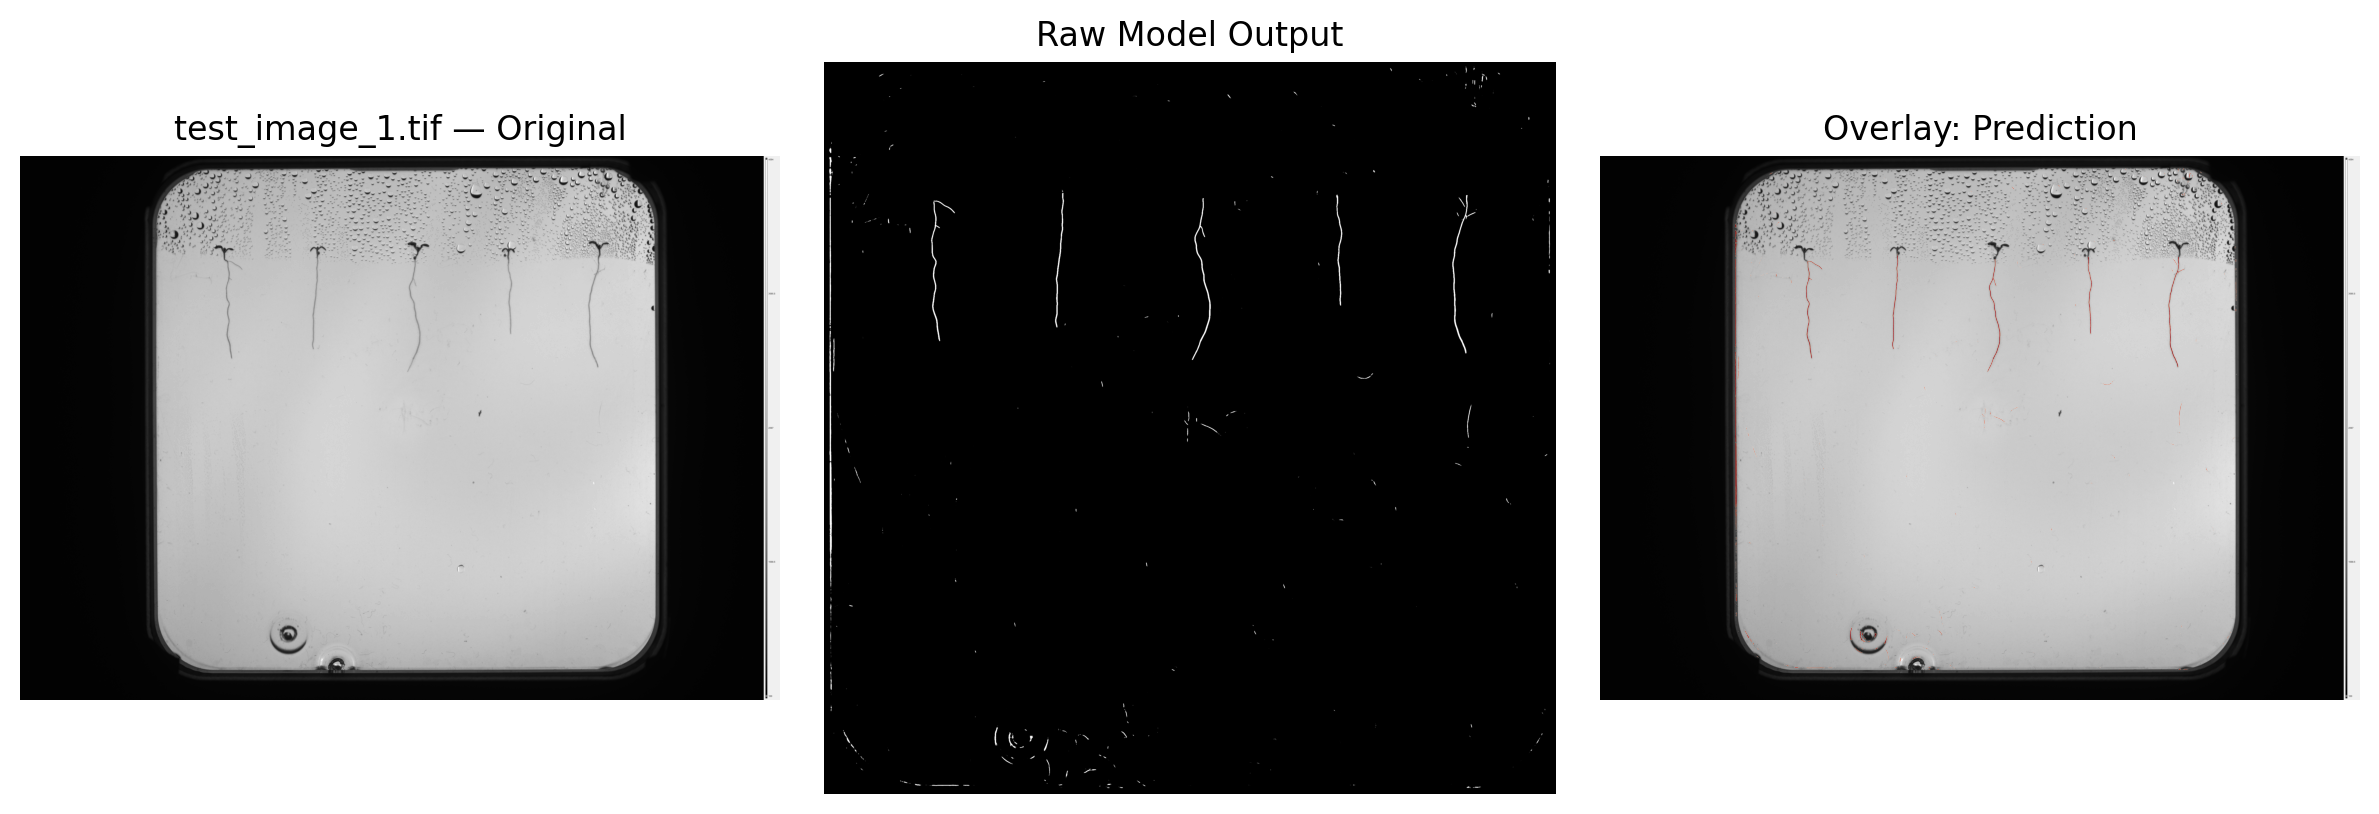


Processing test_image_10.tif


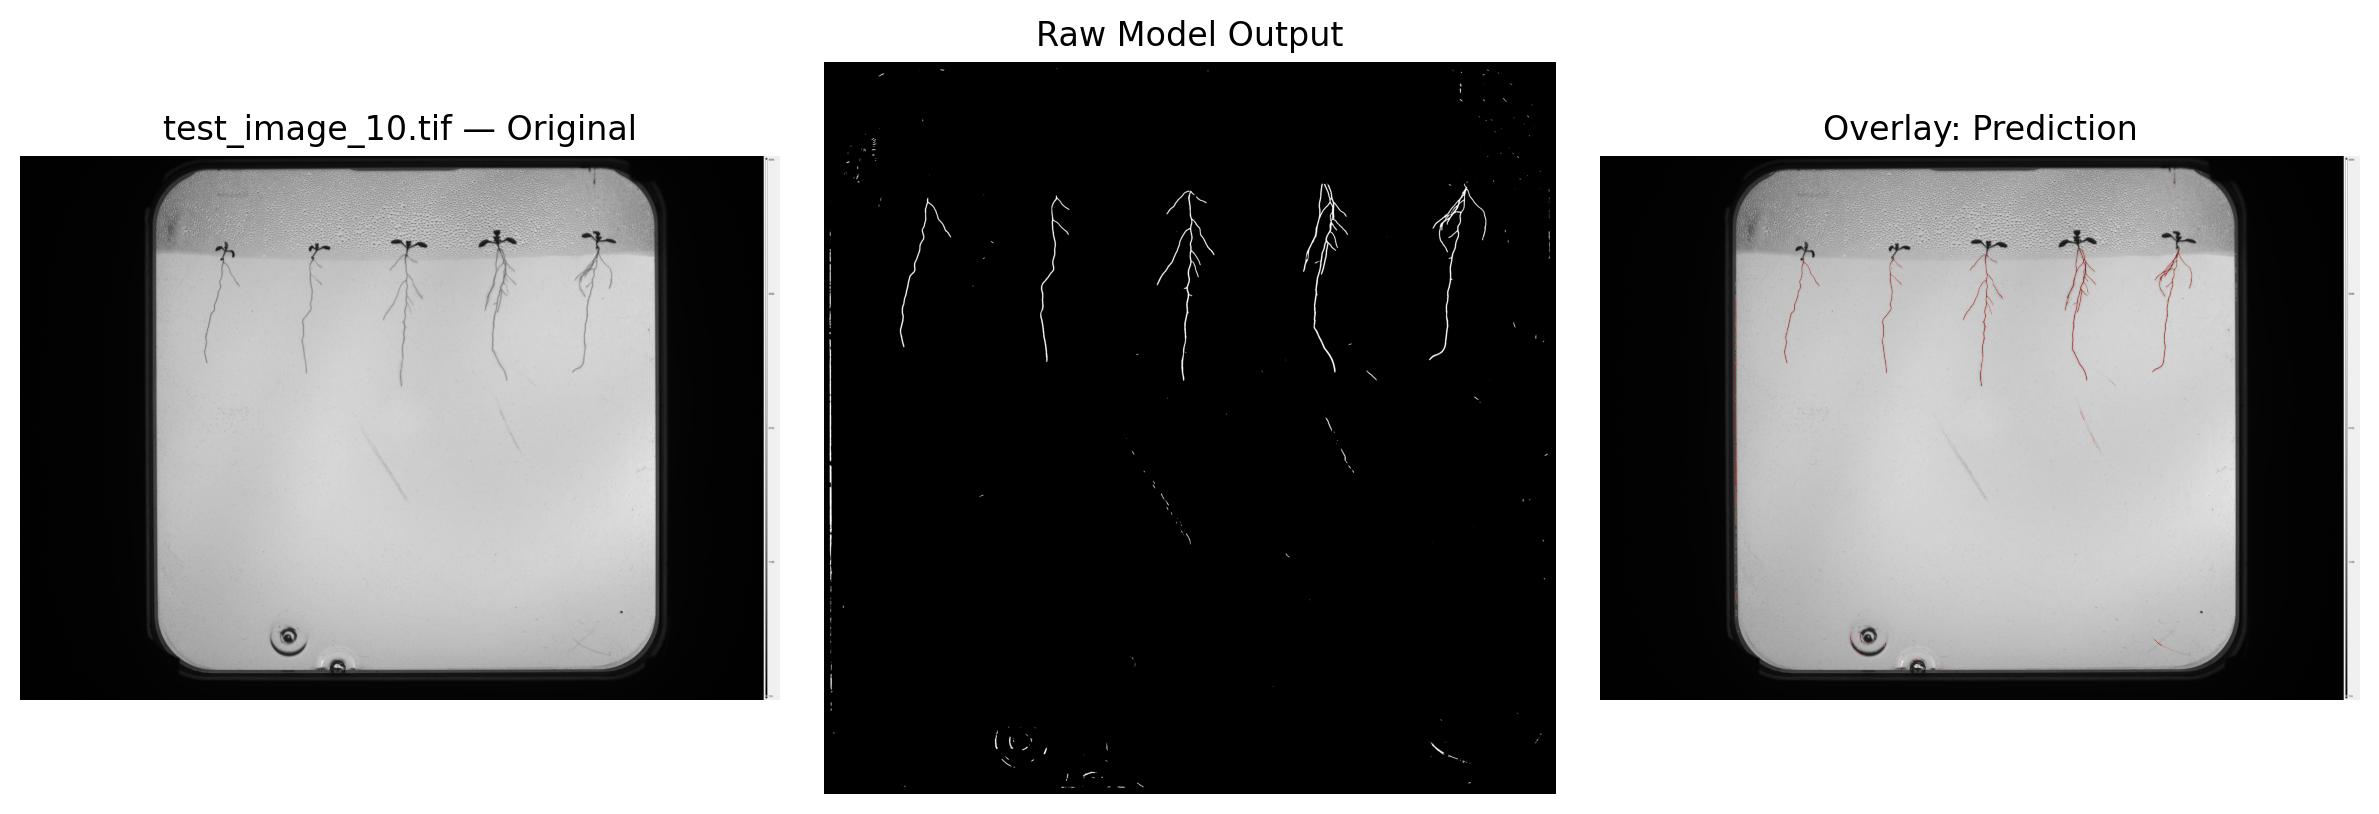


Processing test_image_11.tif


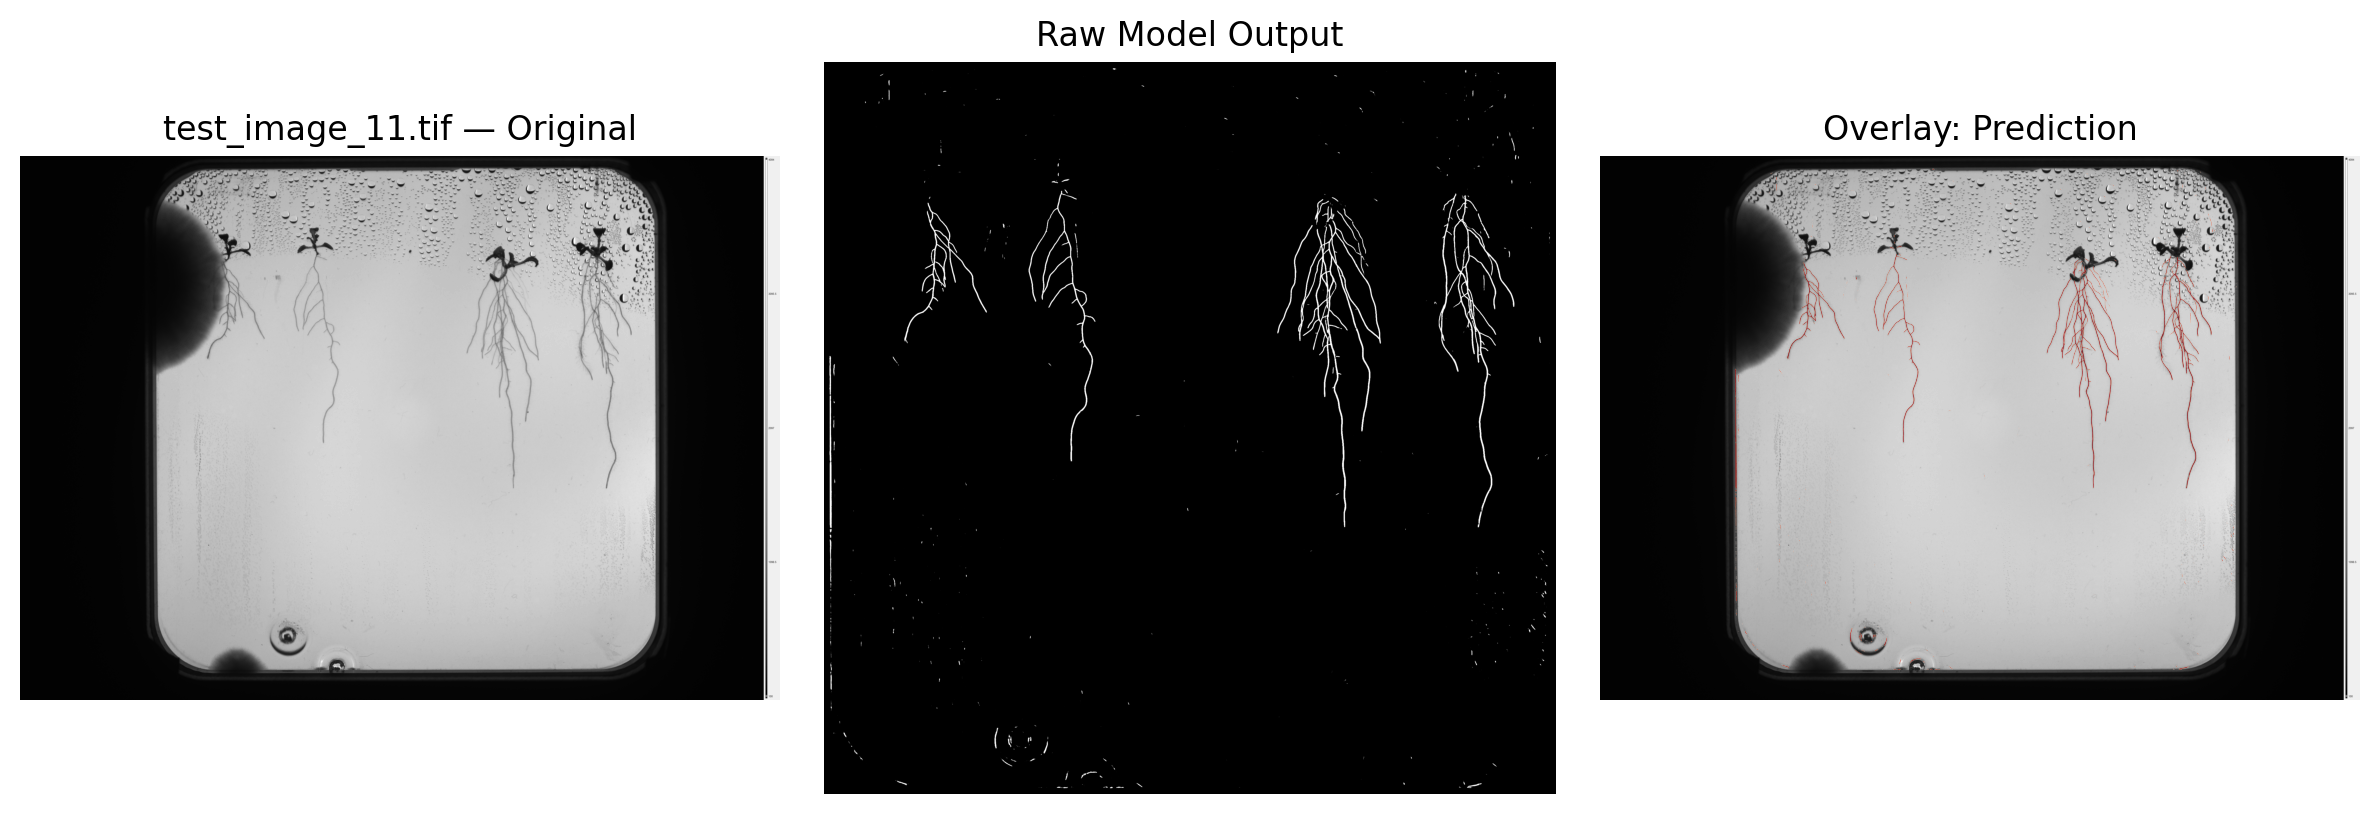


Processing test_image_2.tif


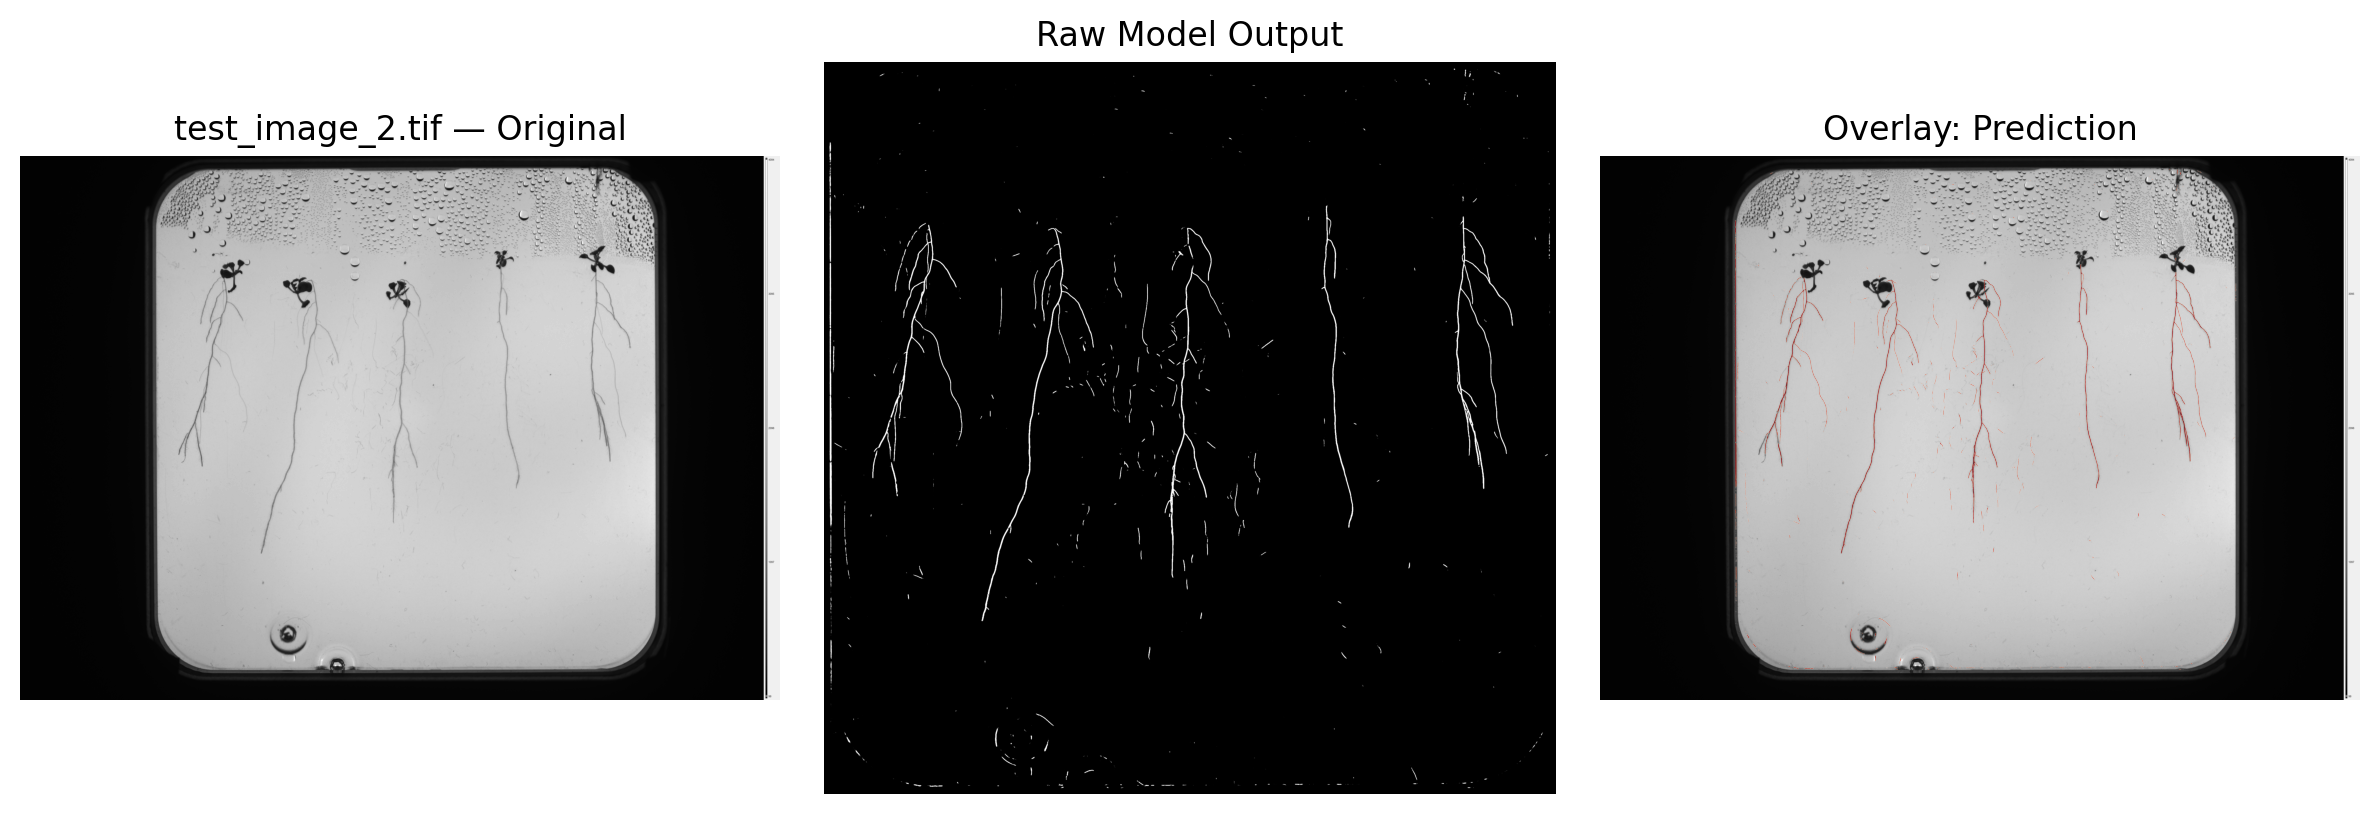


Processing test_image_3.tif


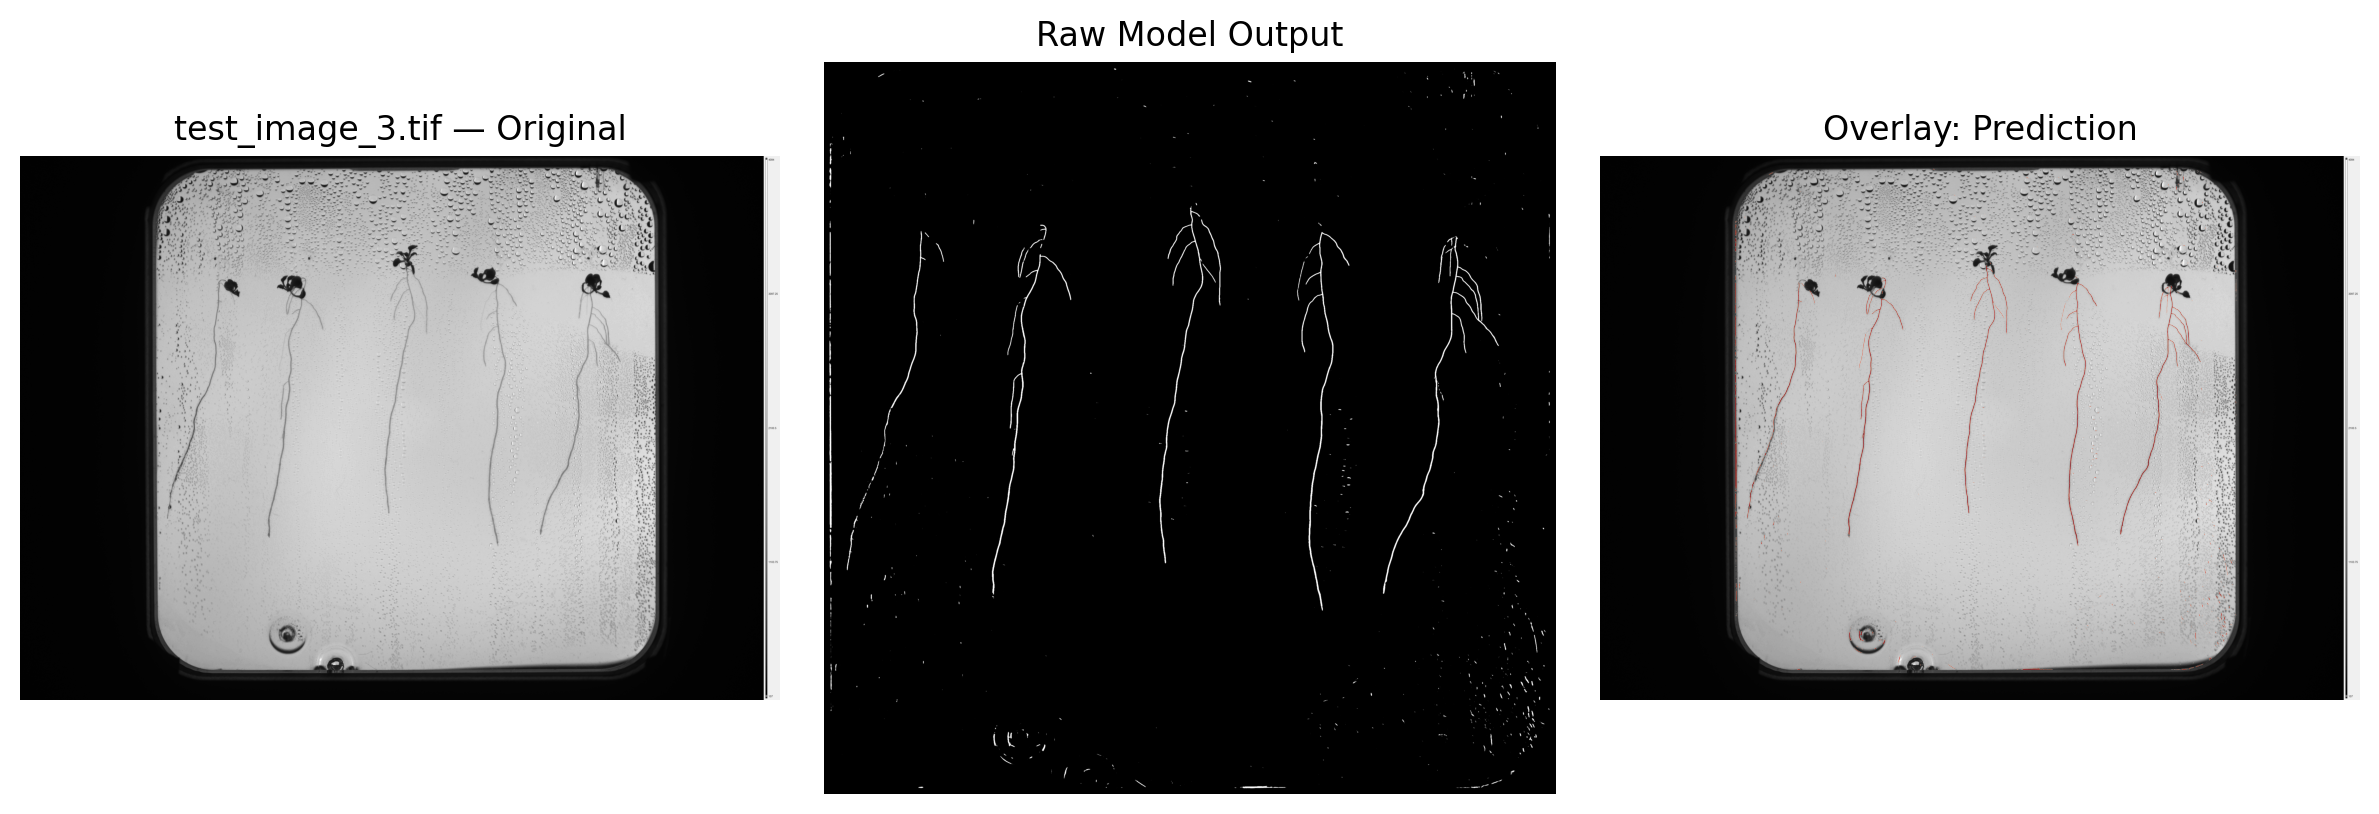


Processing test_image_4.tif


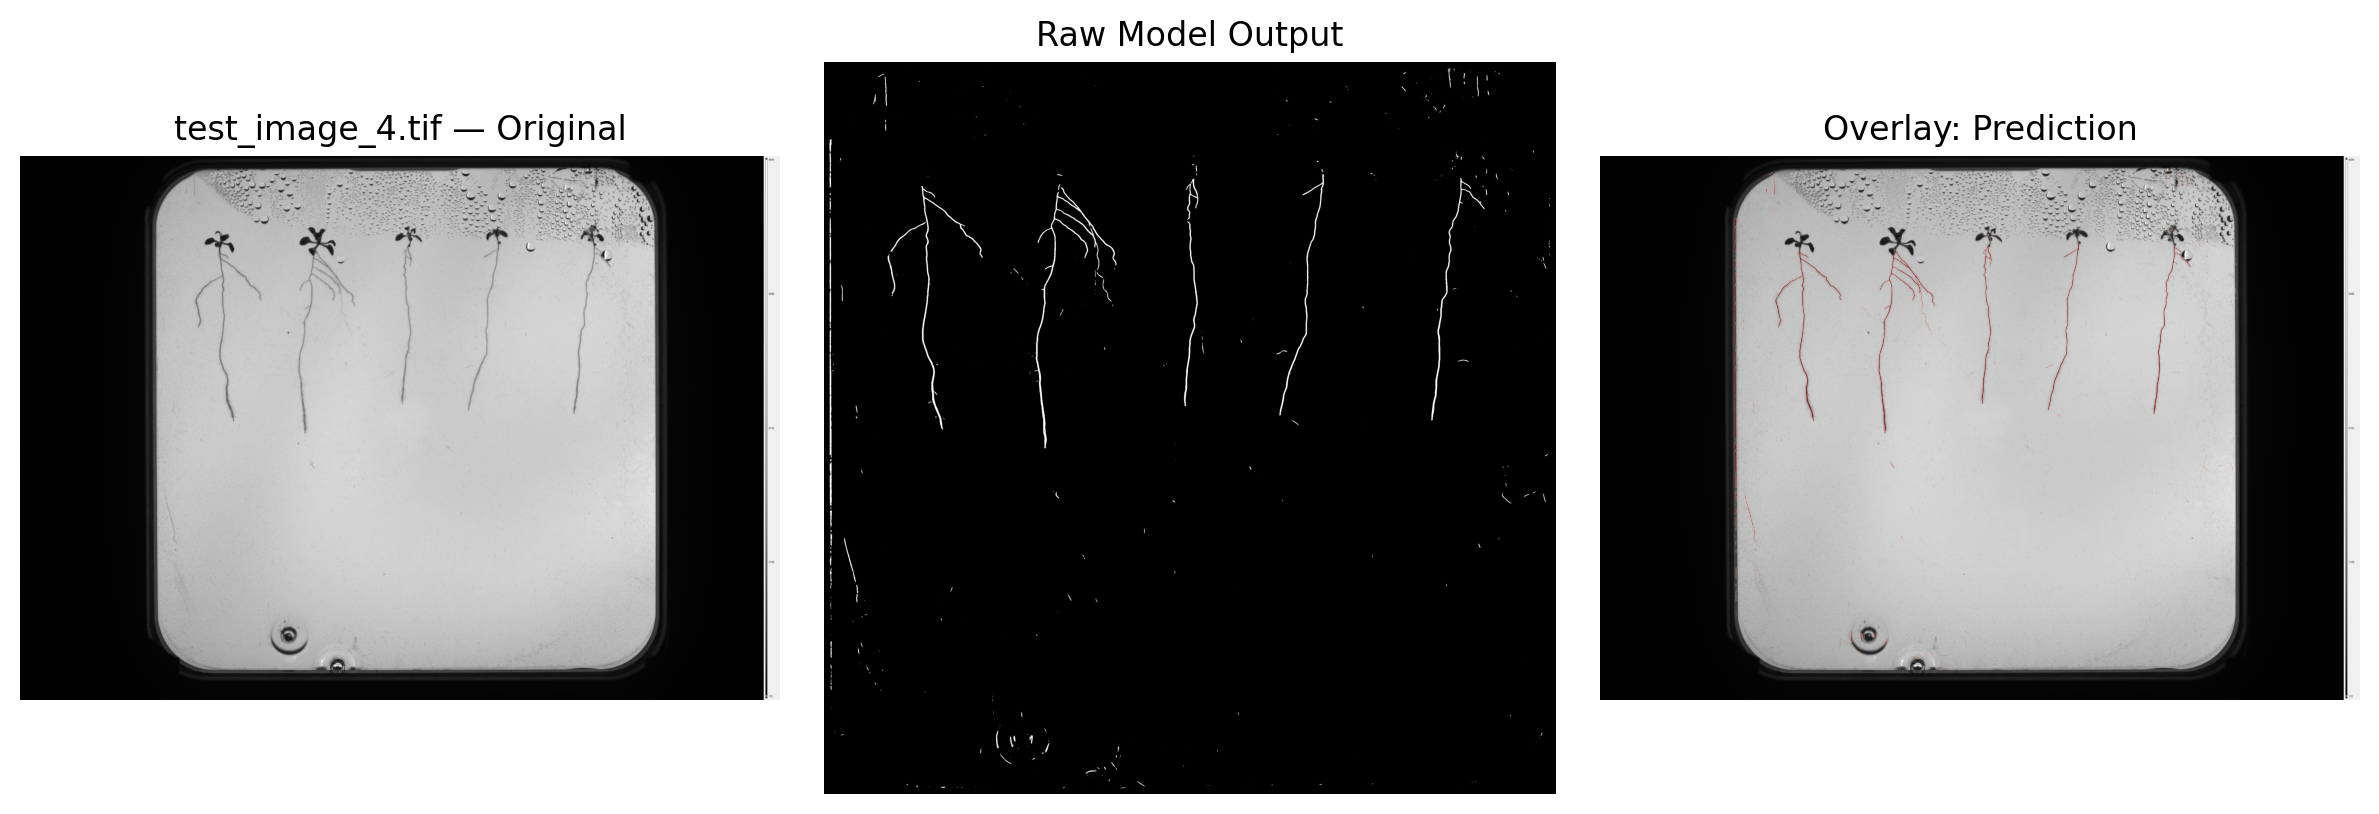


Processing test_image_5.tif


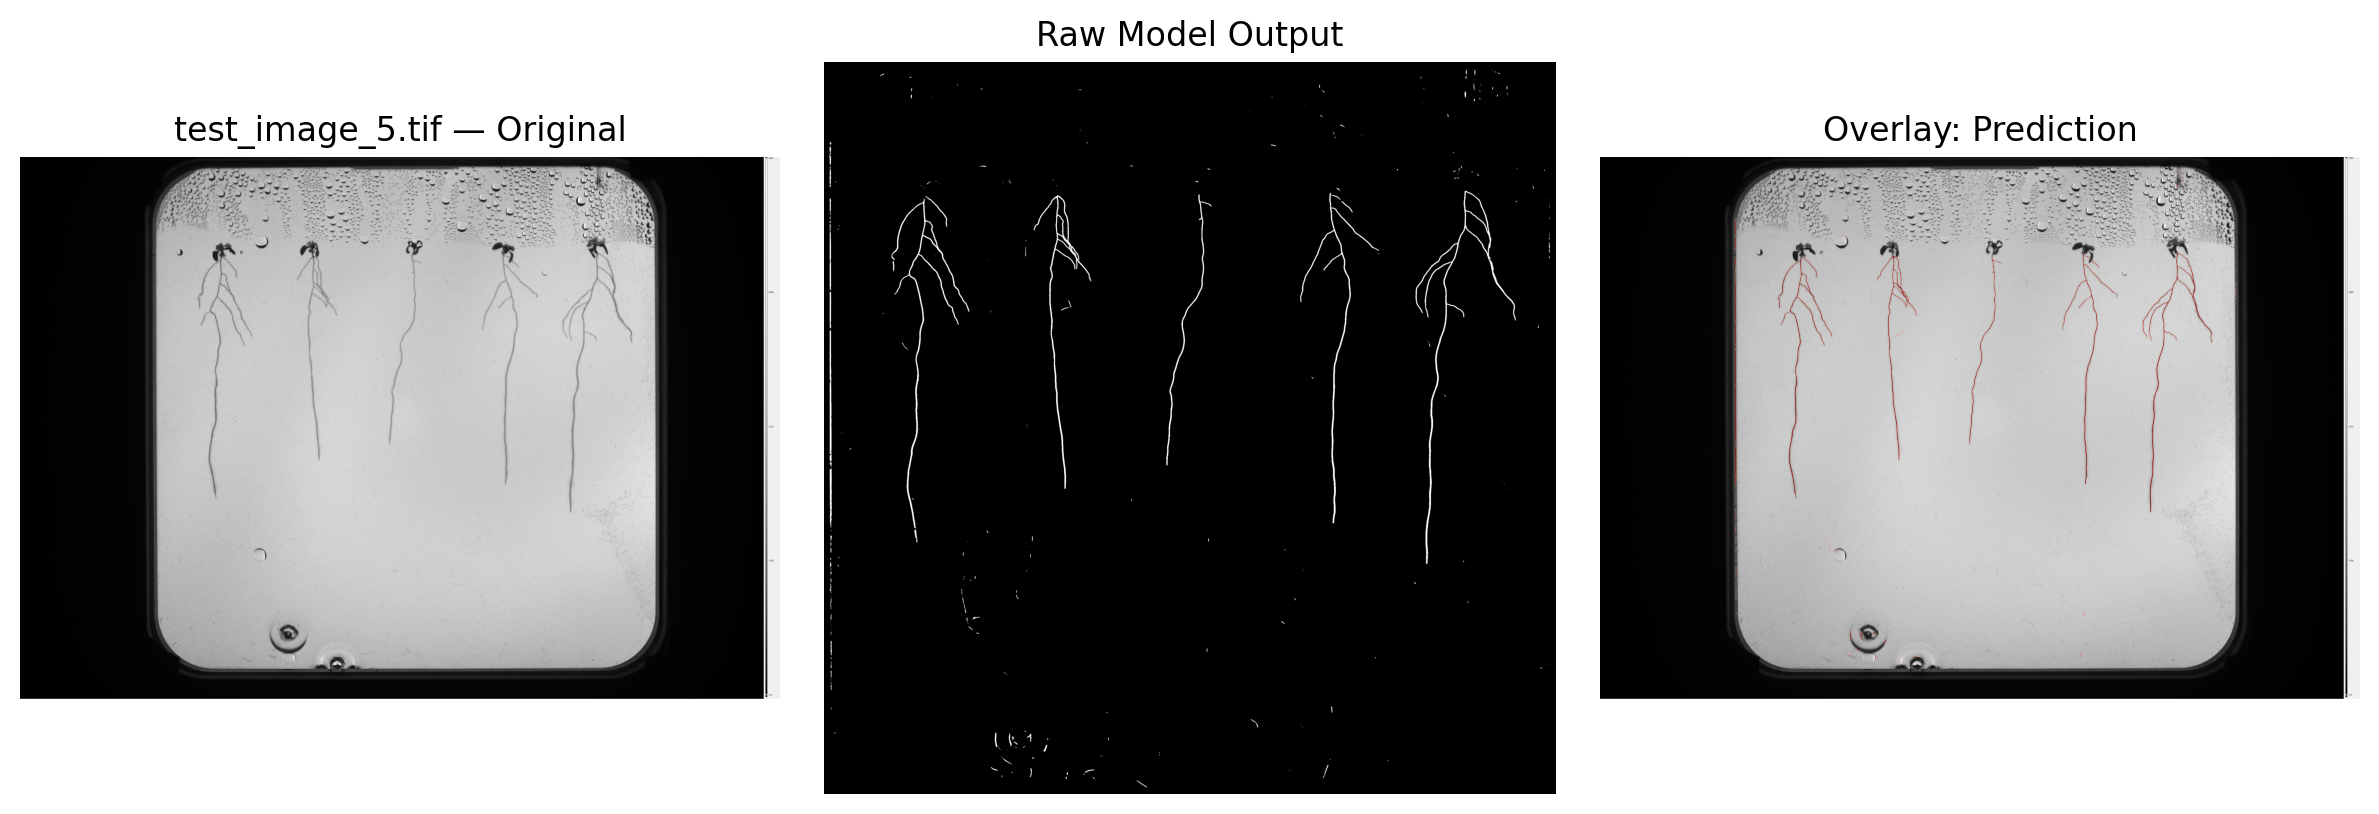


Processing test_image_6.tif


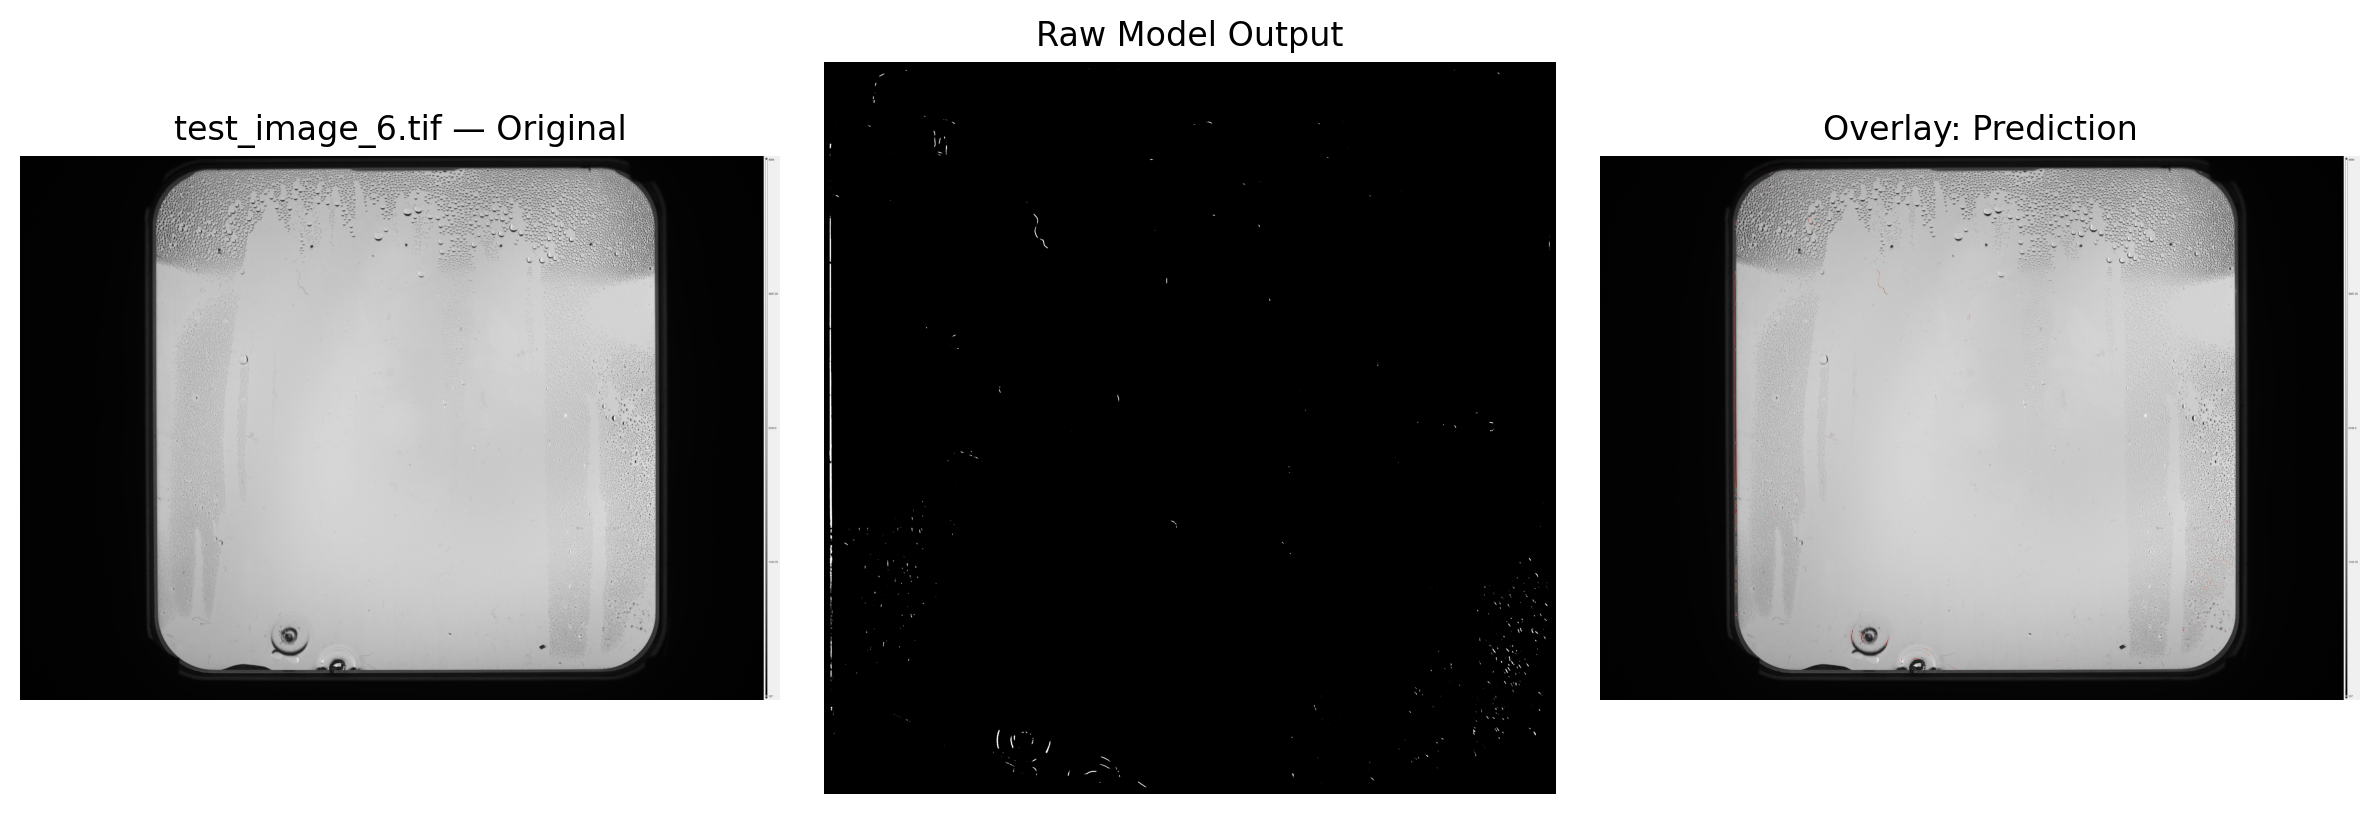


Processing test_image_7.tif


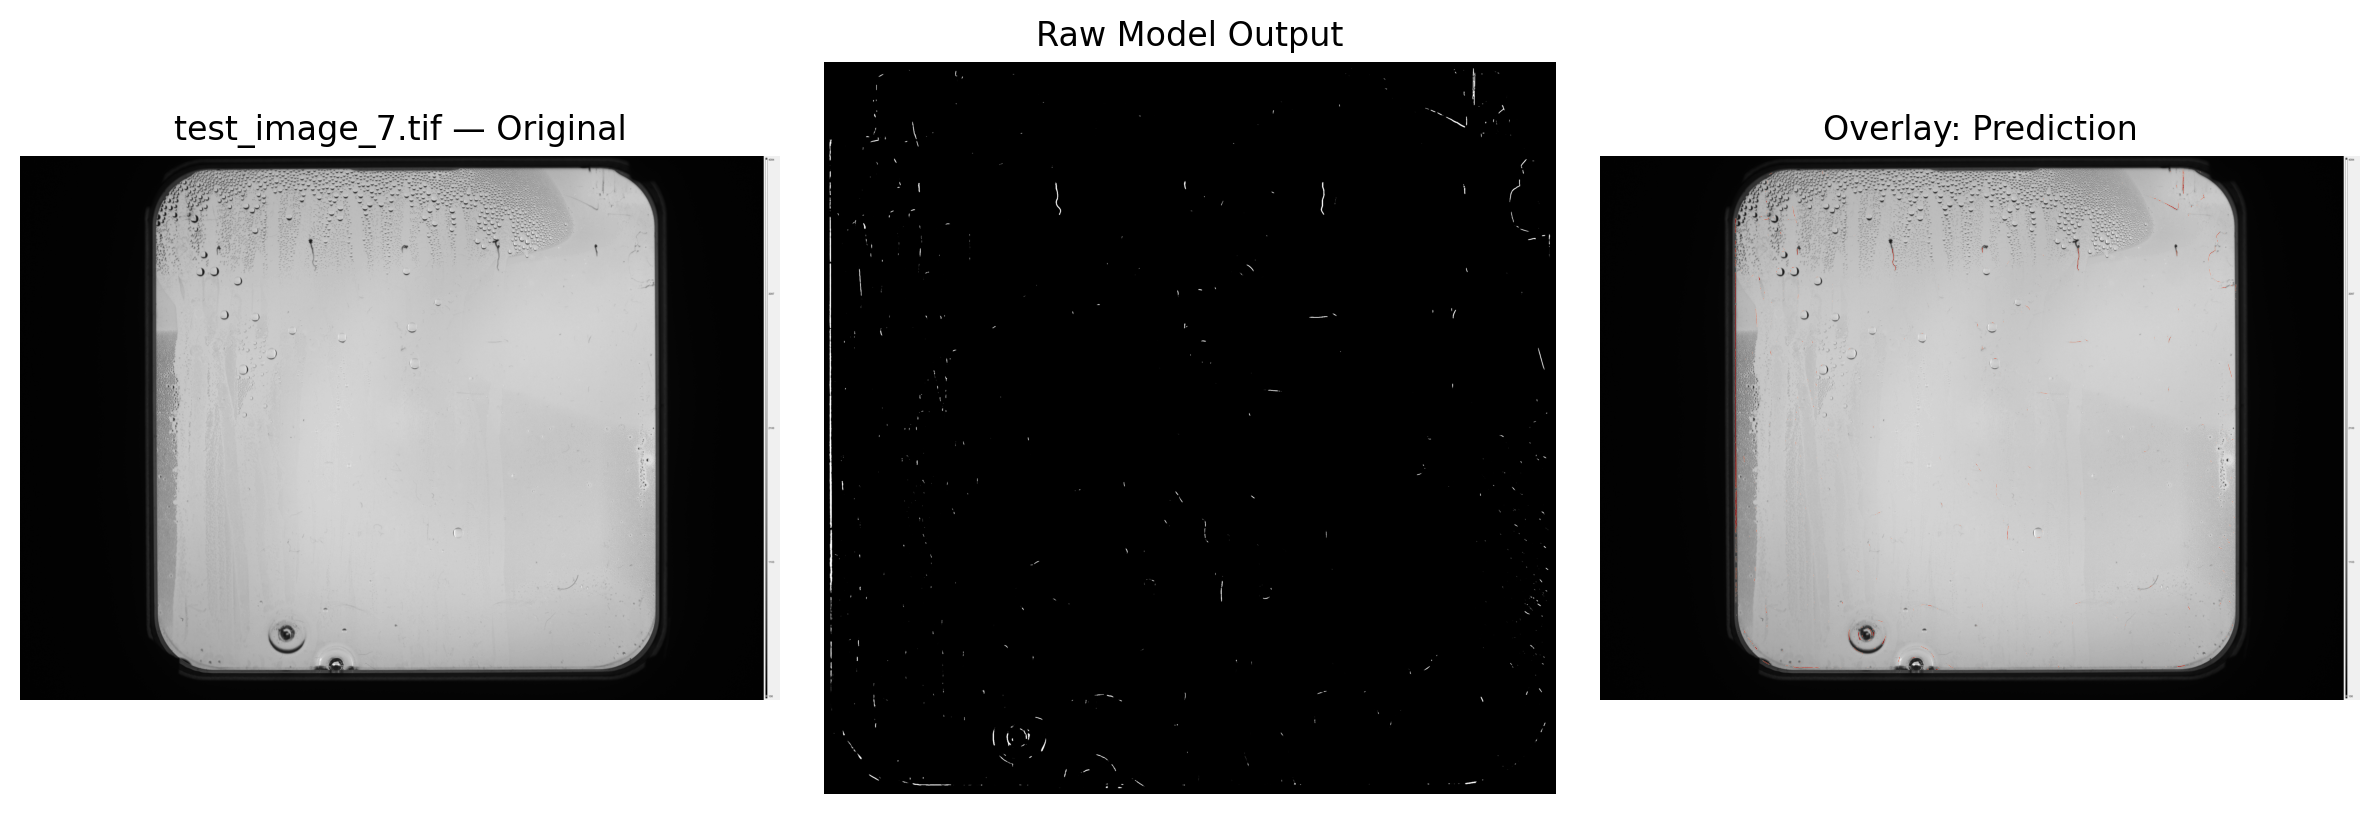


Processing test_image_8.tif


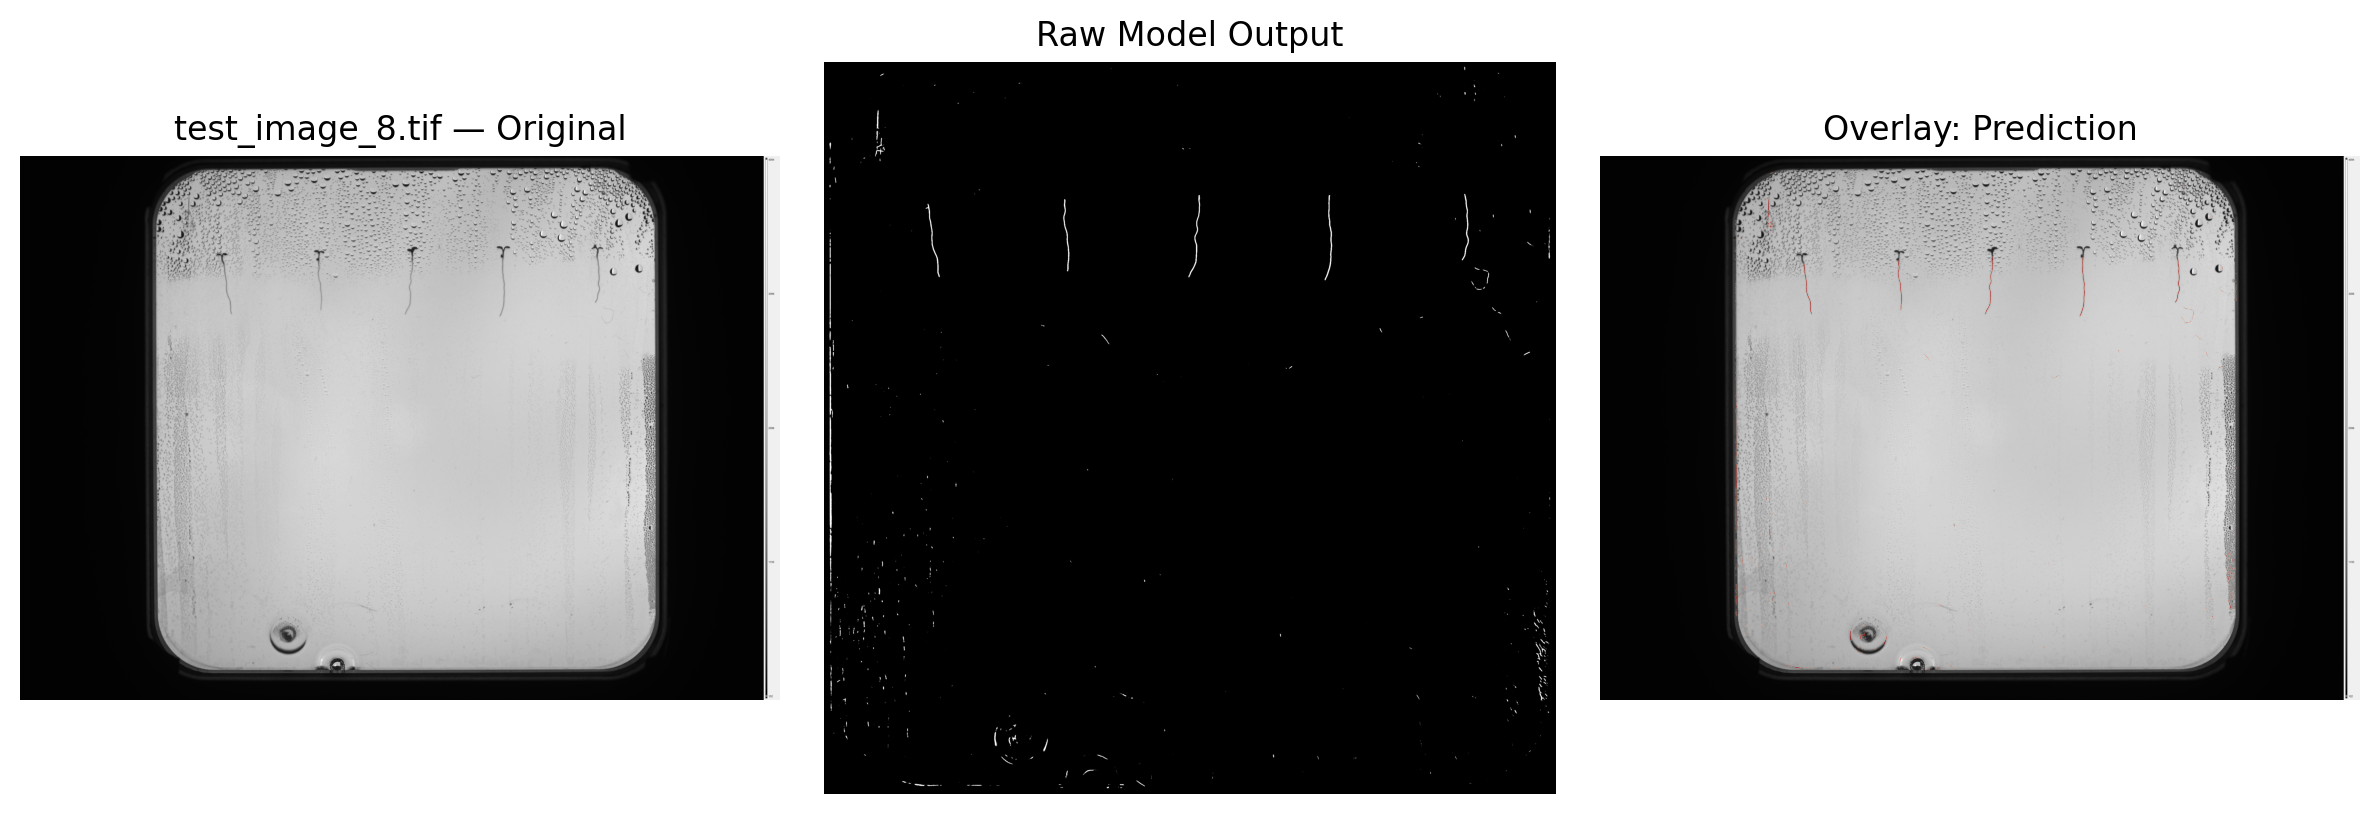


Processing test_image_9.tif


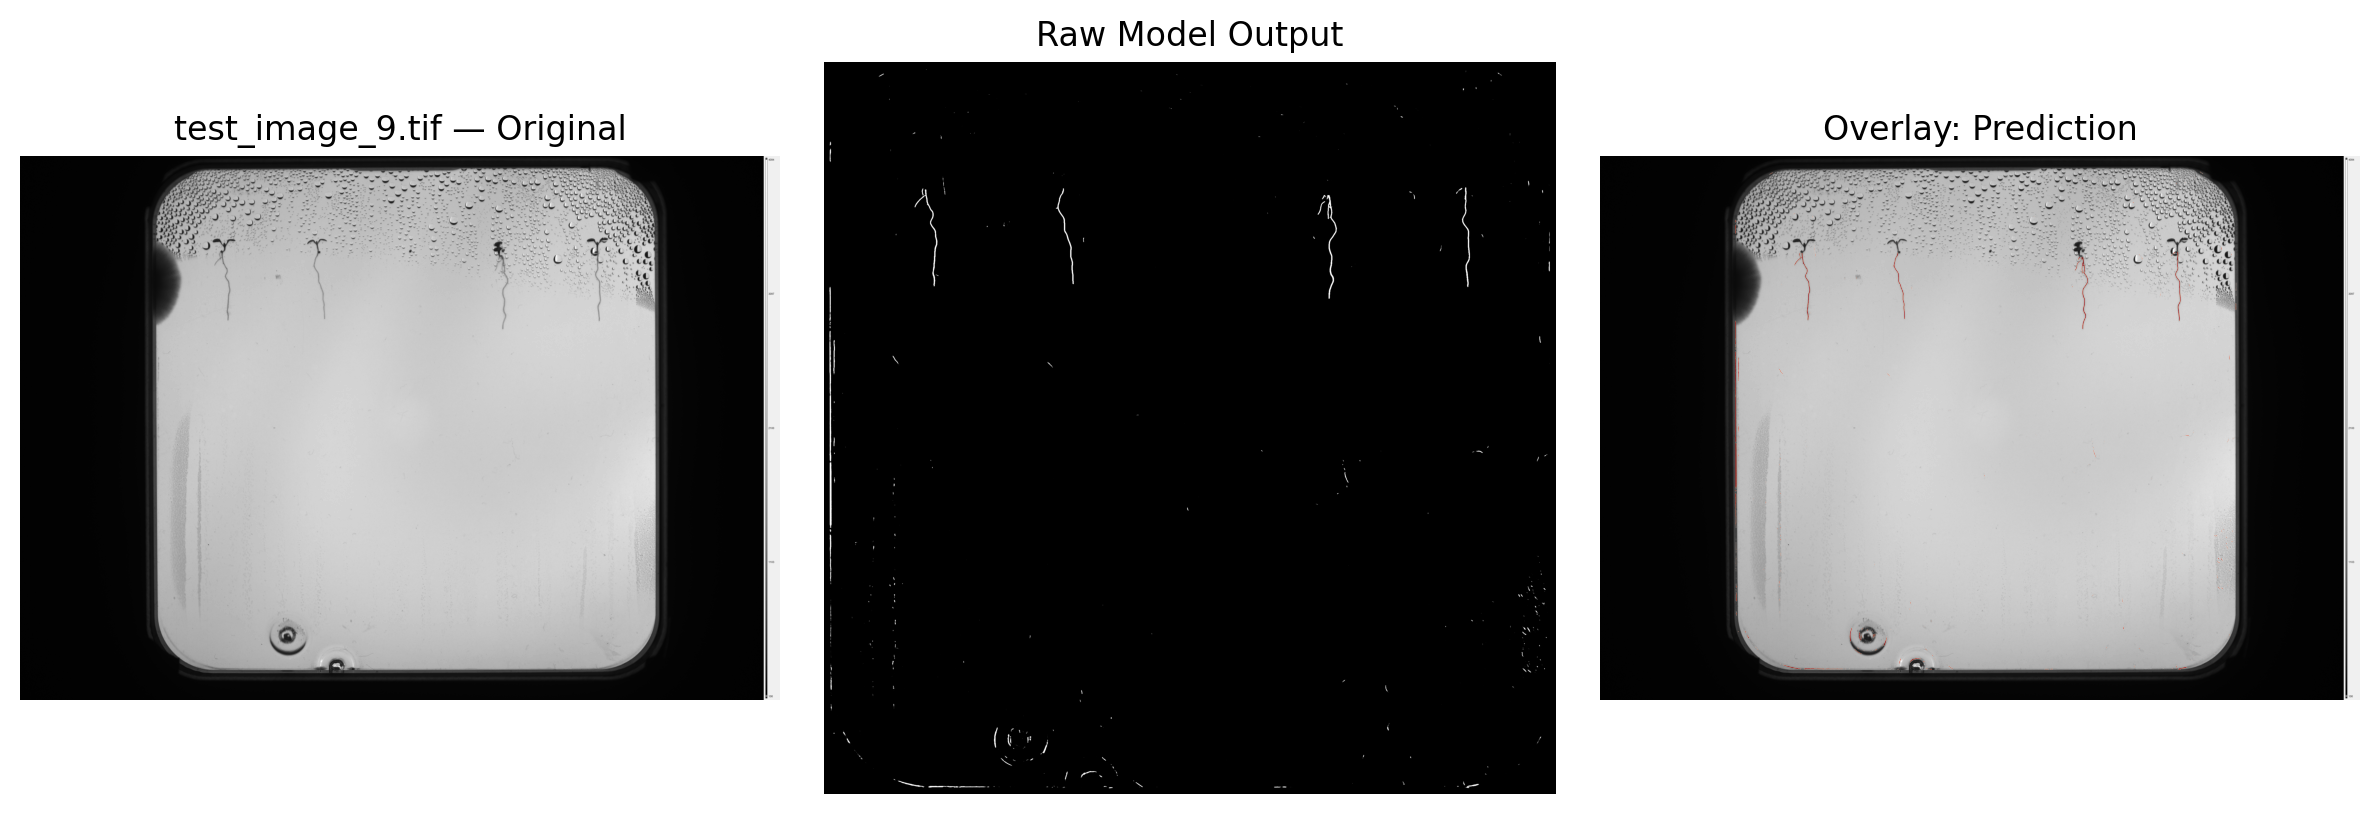

In [20]:
import matplotlib.pyplot as plt

# Predict masks for all test images  
def predict_masks_raw(folder_path, model, patch_size=256):
    results = {}
    for filename in sorted(os.listdir(folder_path)):
        if not filename.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff')):
            continue
        print(f"\nProcessing {filename}")
        image_path = os.path.join(folder_path, filename)
        image = cv2.imread(image_path, 0)
        if image is None:
            continue

        # Preprocess 
        petri_dish, crop_info = cropper(image)
        petri_dish_padded, pad_info = padder(petri_dish, patch_size)

        #Patchify and predict
        patches = patchify(petri_dish_padded, (patch_size, patch_size), step=128)
        ph, pw = patches.shape[:2]
        patches_rgb = np.repeat(patches, 3, axis=-1)  
        model_in = patches_rgb.reshape(-1, patch_size, patch_size, 3) / 255.0

        preds = model.predict(model_in, verbose=0)
        preds = preds.squeeze().reshape(ph, pw, patch_size, patch_size)
        predicted_mask = unpatchify(preds, petri_dish_padded.shape)

        # Unpad & uncrop 
        unpadded = unpadder(predicted_mask, pad_info)
        aligned  = uncropper(unpadded, crop_info)
        results[filename] = {'mask': aligned, 'crop_info': crop_info, 'pad_info': pad_info}

        # Visualization 
        f, ax = plt.subplots(1, 3, dpi=200, figsize=(12, 4))
        ax[0].imshow(image, cmap='gray')
        ax[0].set_title(f"{filename} — Original")
        ax[0].axis('off')

        ax[1].imshow(predicted_mask, cmap='gray')
        ax[1].set_title("Raw Model Output")
        ax[1].axis('off')

        ax[2].imshow(image, cmap='gray')
        ax[2].imshow(aligned, cmap='Reds', alpha=(aligned > 0.1) * 0.6)
        ax[2].set_title("Overlay: Prediction")
        ax[2].axis('off')

        plt.tight_layout()
        plt.show()

    return results

# Run segmentation
raw_predictions = predict_masks_raw(test_folder, model, patch_size)



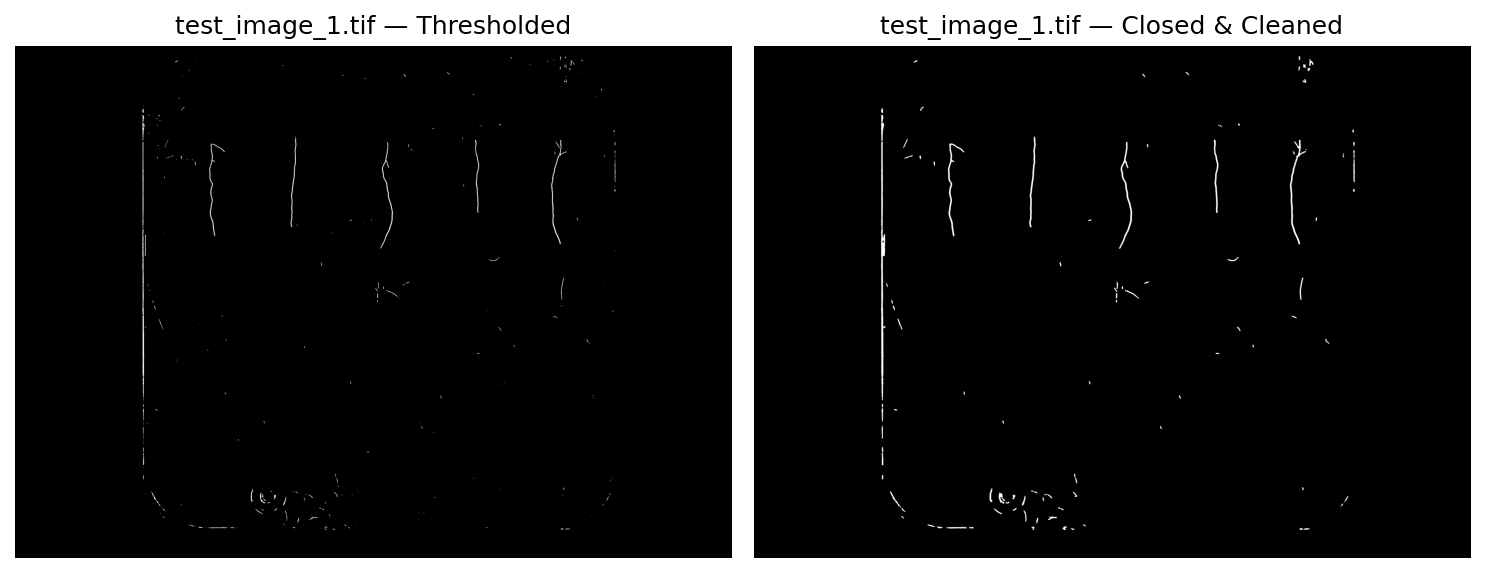

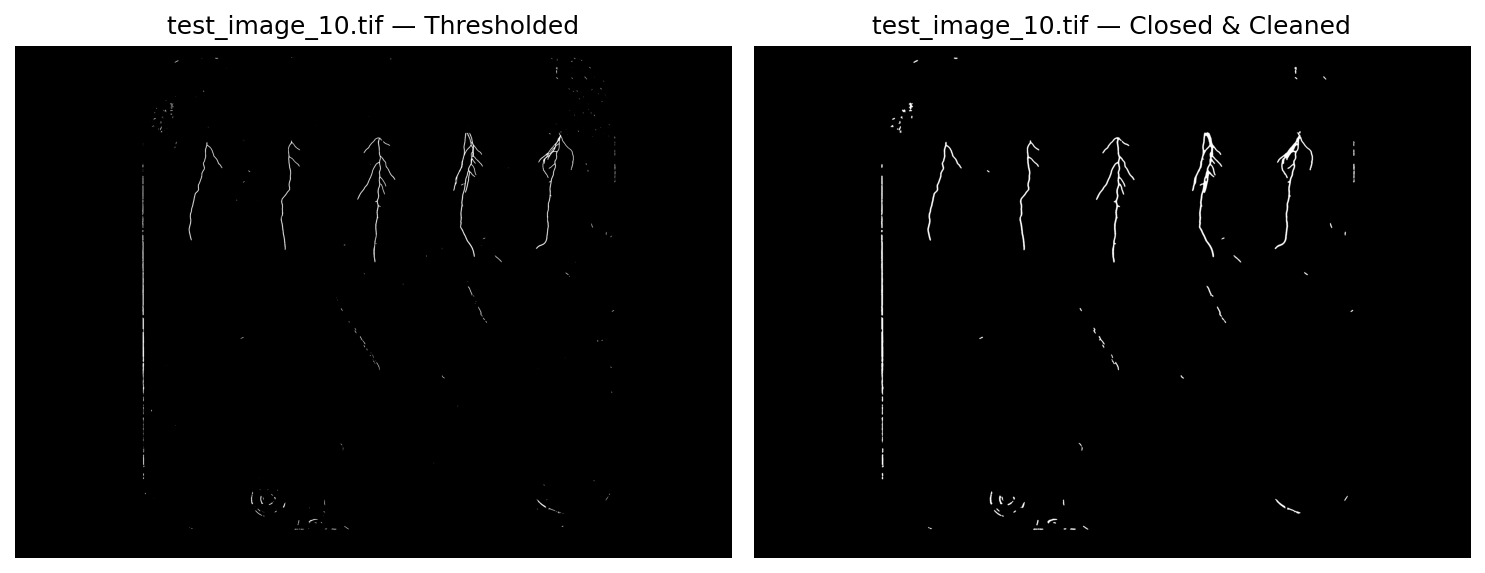

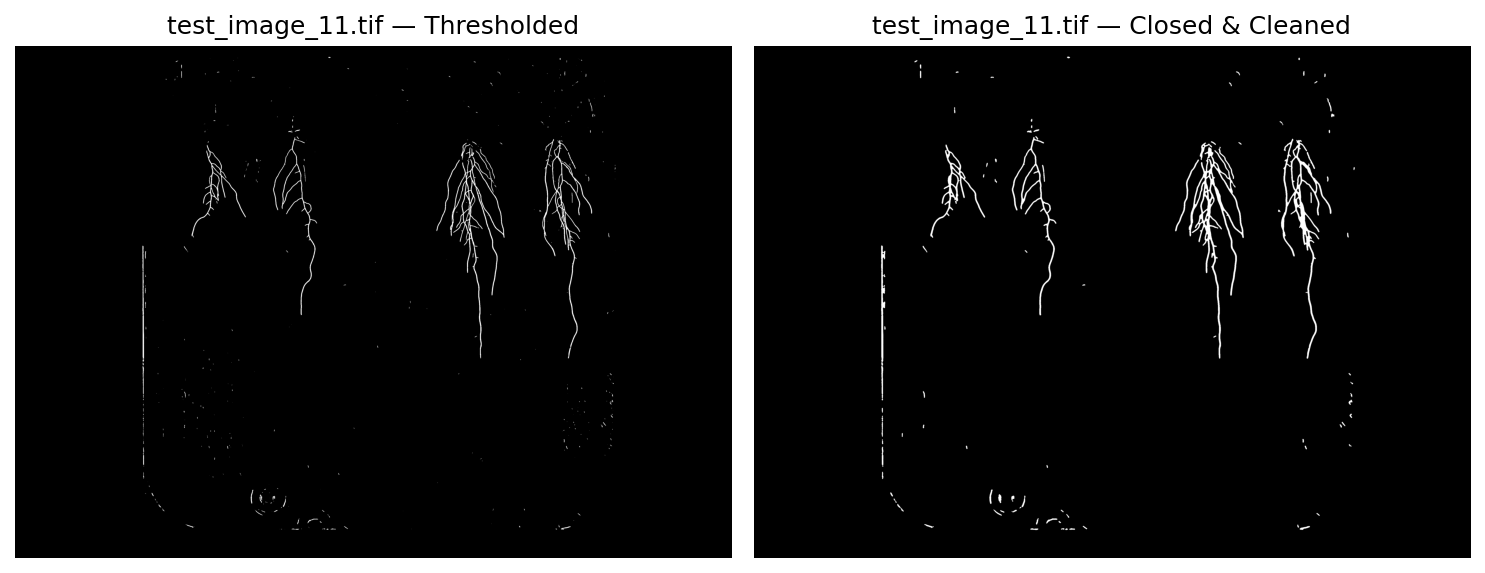

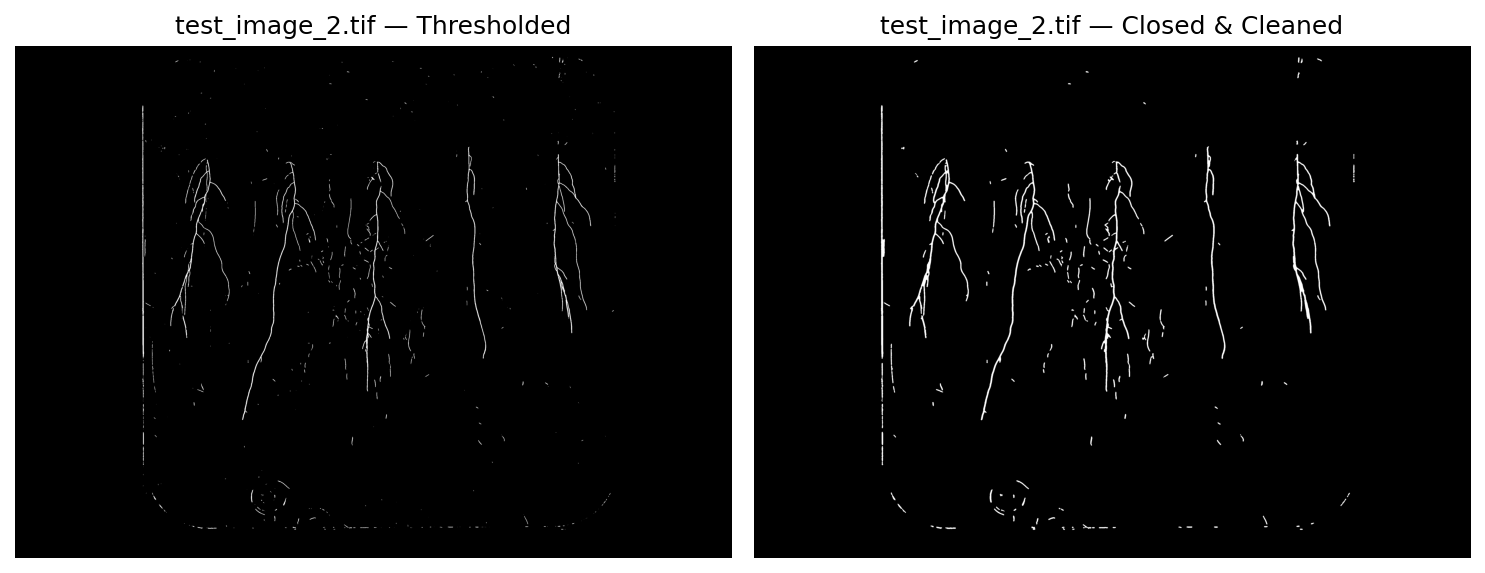

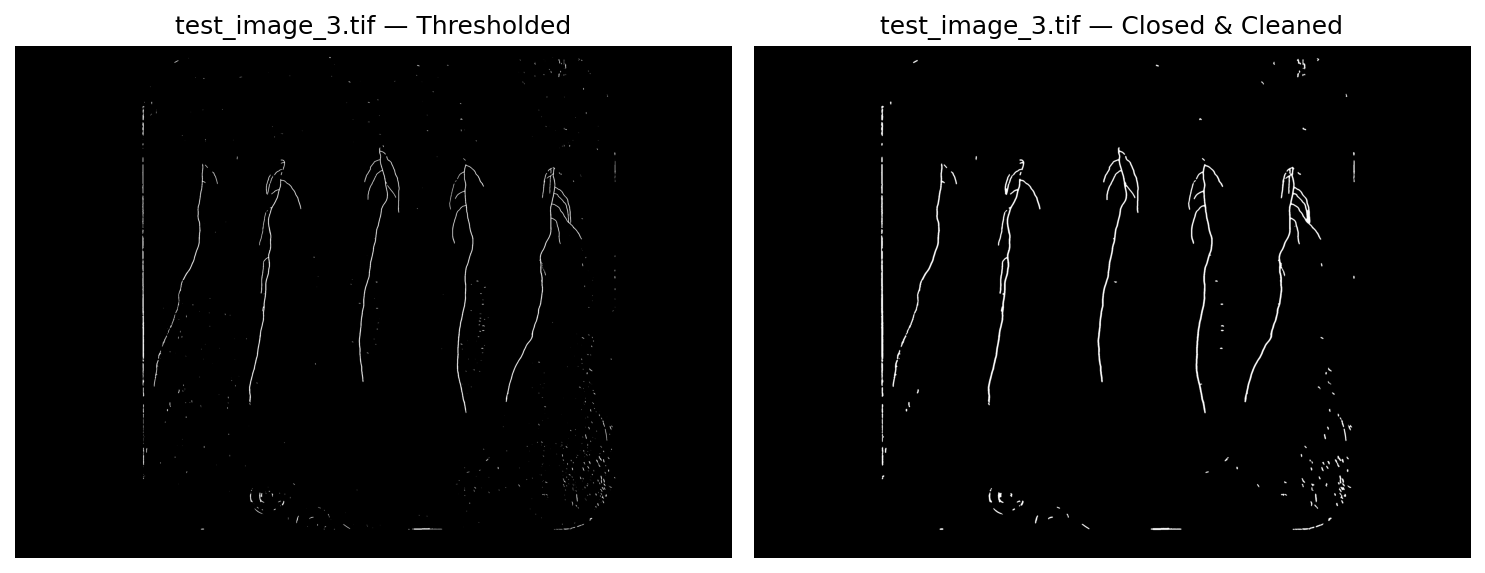

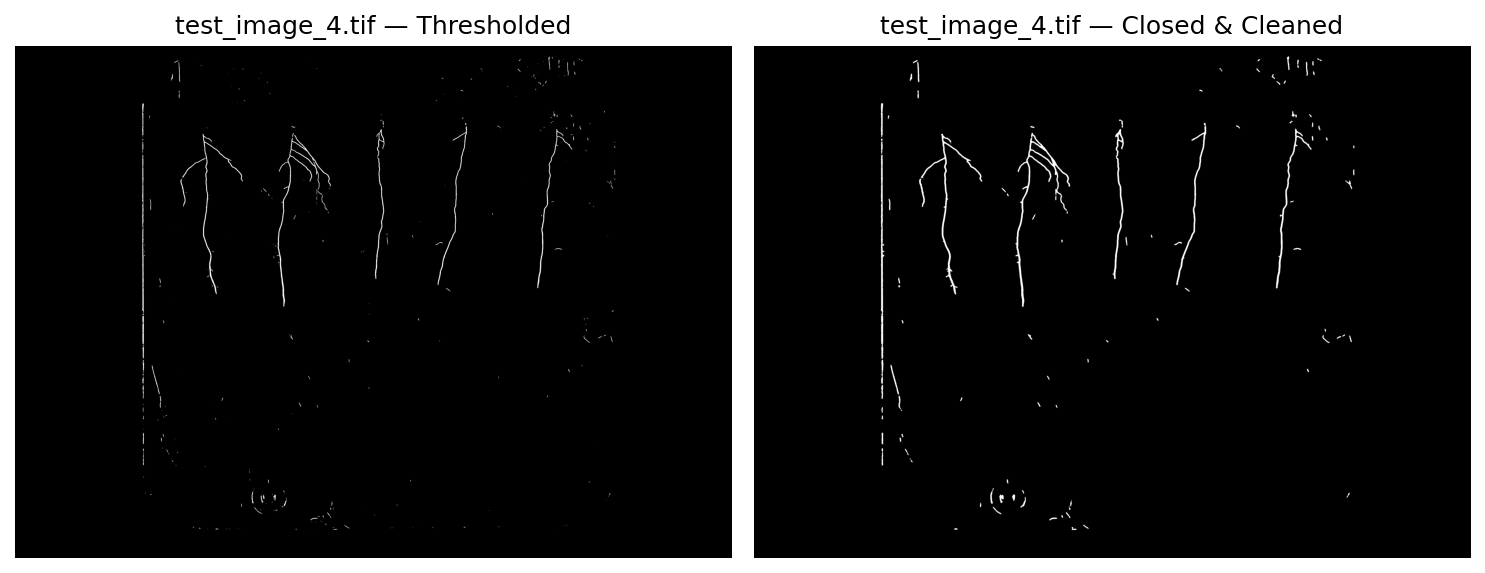

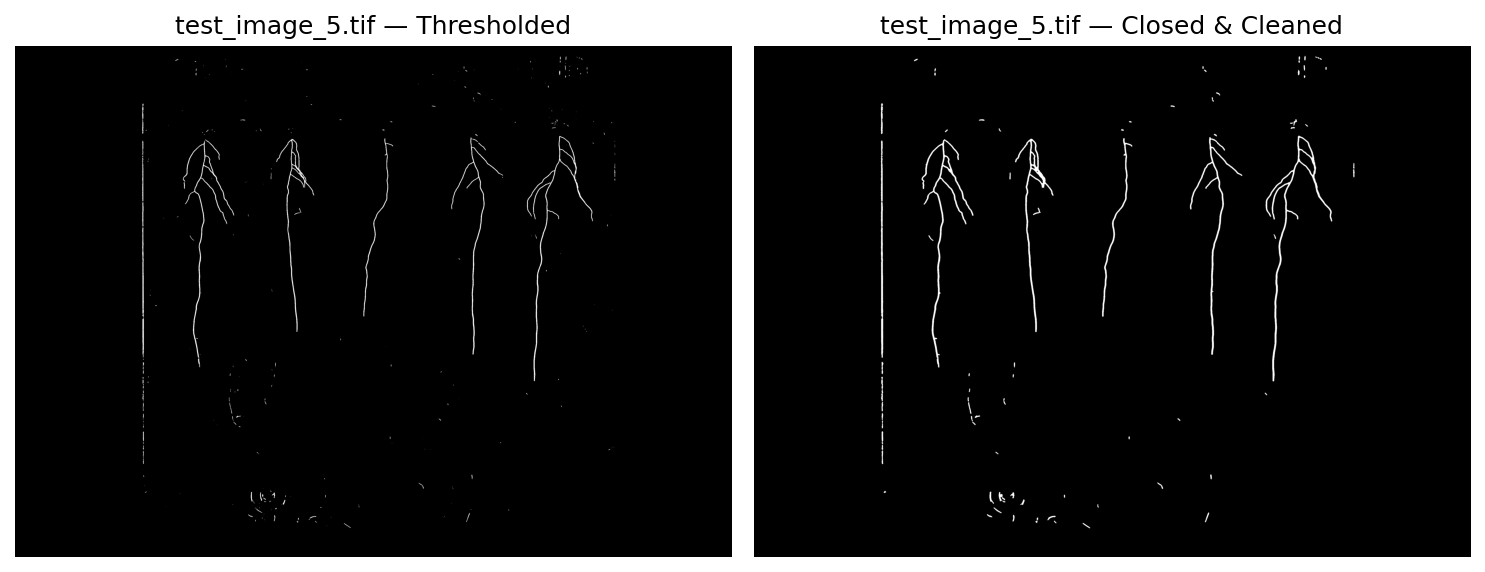

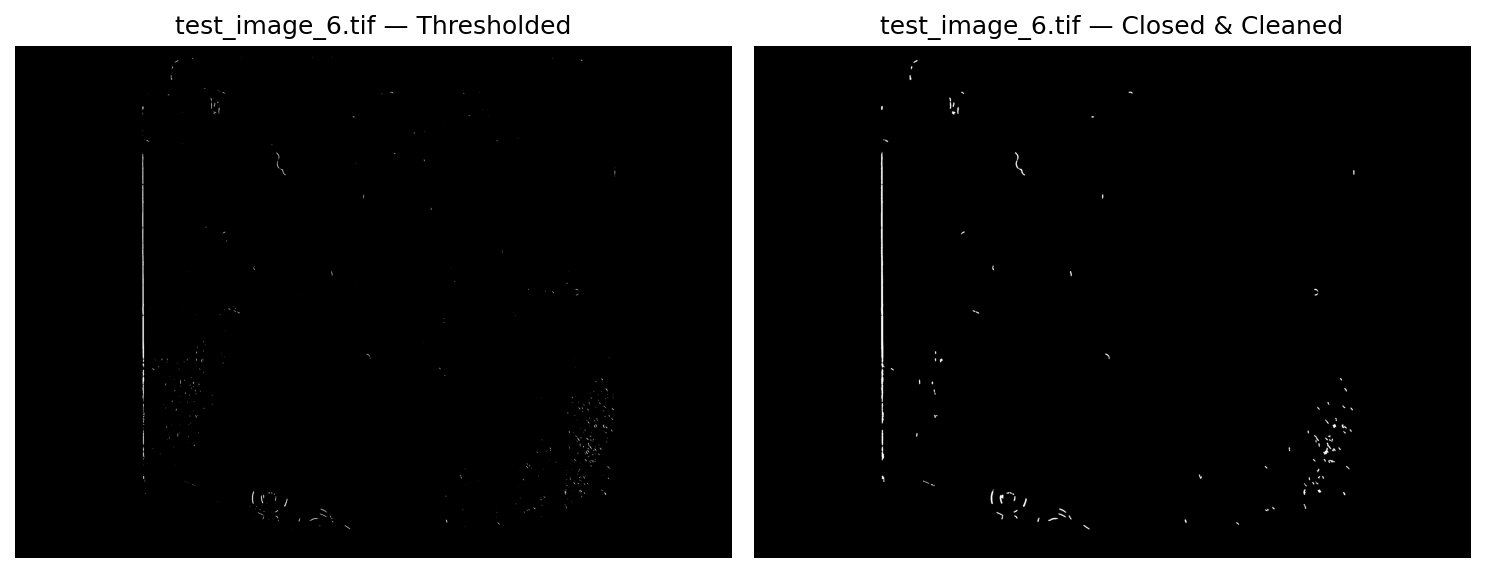

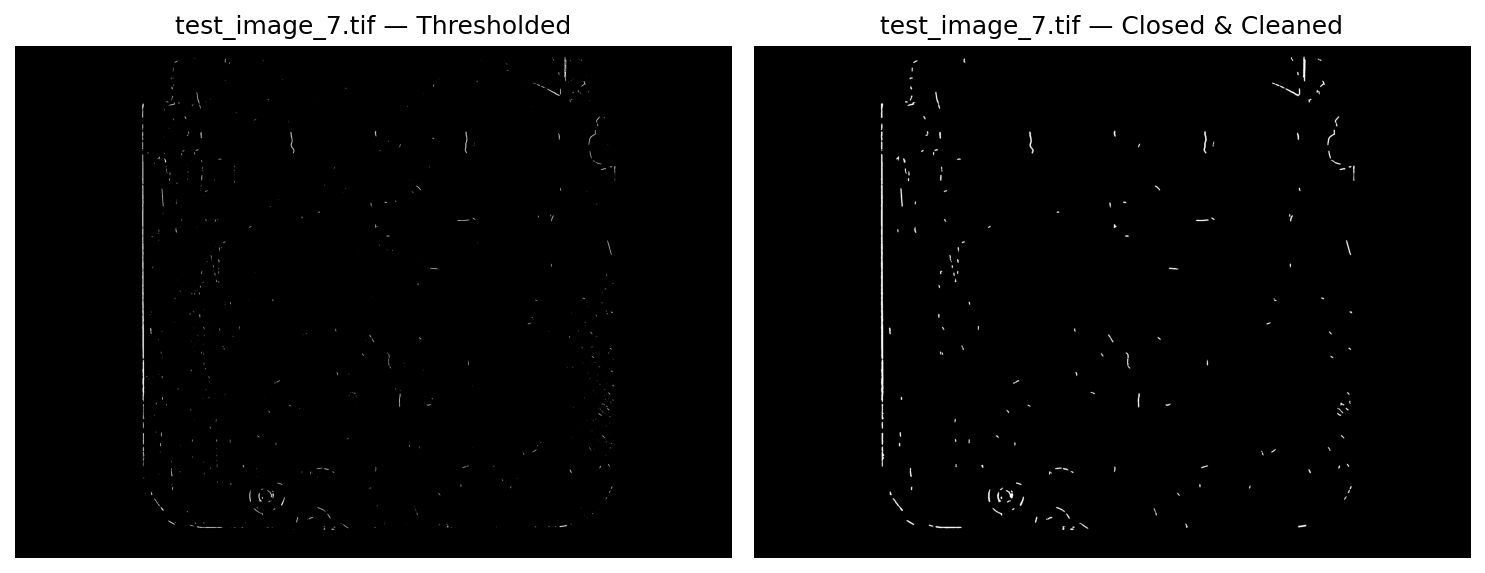

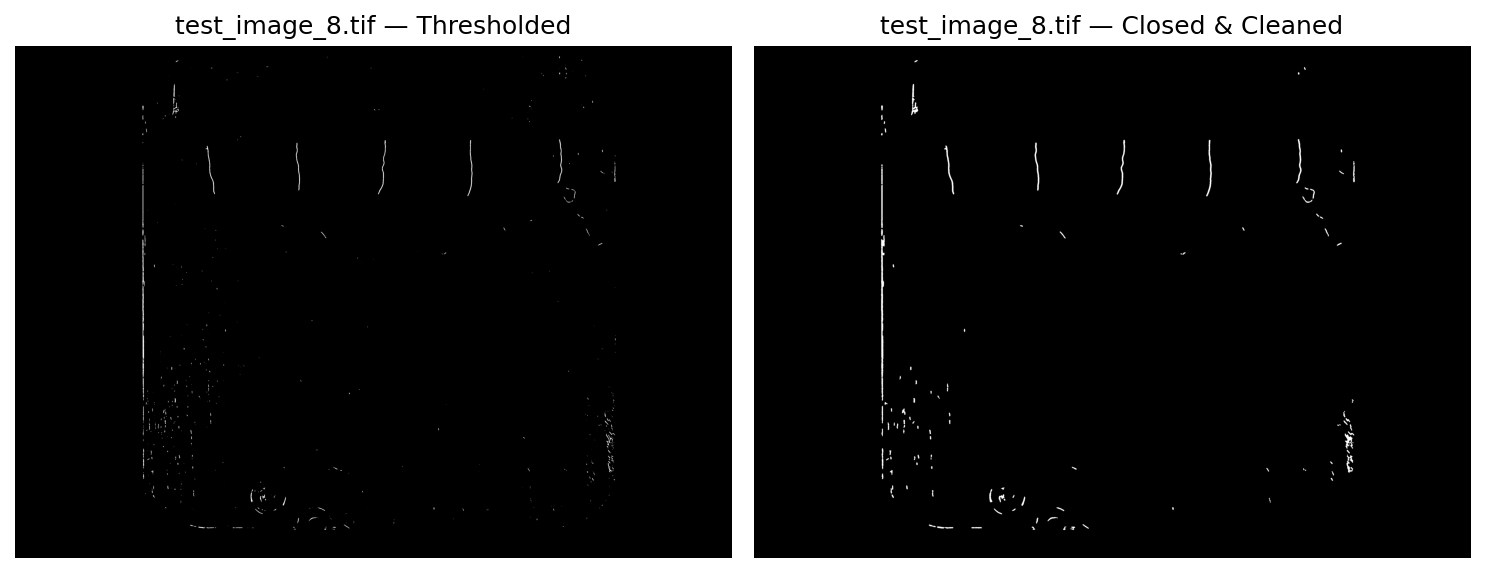

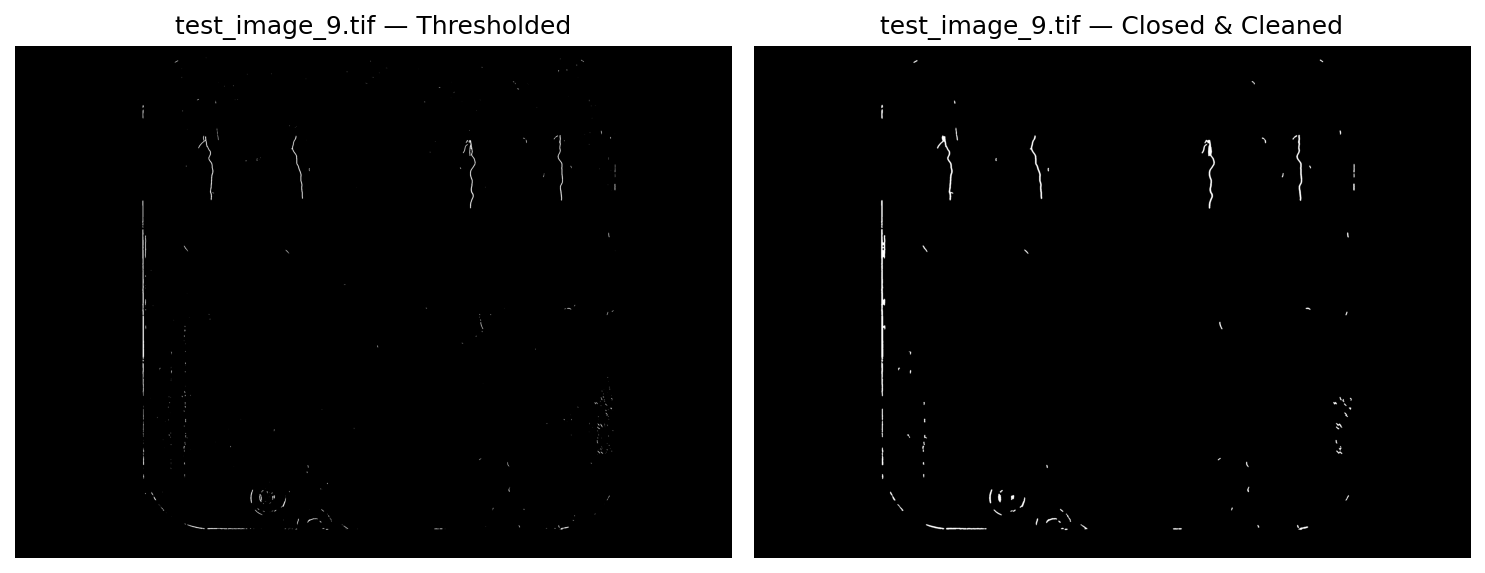

In [21]:
# Threshold + Morphological Closing + small-blob cleanup
thresholded_masks = {
    name: (raw['mask'] > threshold).astype(np.uint8)
    for name, raw in raw_predictions.items()
}

closed_masks = {}
kernel = cv2.getStructuringElement(kernel_shape, kernel_size)

for name, binary in thresholded_masks.items():
    base = binary.copy()

    # Morphological closing
    dilated = cv2.dilate(base, kernel, iterations=dilate_iterations)
    closed  = cv2.erode(dilated, kernel, iterations=erode_iterations)

    # Remove tiny blobs (<100 px)
    min_blob_area = 100
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(closed)
    clean = np.zeros_like(closed)
    for i in range(1, num_labels):
        if stats[i, cv2.CC_STAT_AREA] >= min_blob_area:
            clean[labels == i] = 1
    closed_masks[name] = clean

    # -Visualization 
    fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=150)
    axs[0].imshow(base * 255, cmap='gray')
    axs[0].set_title(f'{name} — Thresholded')
    axs[0].axis('off')

    axs[1].imshow(clean * 255, cmap='gray')
    axs[1].set_title(f'{name} — Closed & Cleaned')
    axs[1].axis('off')

    plt.tight_layout()
    plt.show()


In [22]:
# Dish-width crop + top crop 
dish_cropped_masks = {}
for name, closed in closed_masks.items():
    ci = raw_predictions[name]['crop_info']
    xs, size = ci['x_start'], ci['crop_size']
    xe = min(xs + size, closed.shape[1])
    horiz = closed[:, xs:xe]
    h = horiz.shape[0]
    t = int(h * top_crop_ratio)
    dish_cropped_masks[name] = horiz[t:, :]


In [23]:
# Segment likely primary root region per plant band 
segmented_root_masks = {}
for name, mask in dish_cropped_masks.items():
    h, w = mask.shape
    band_width = w / num_plants
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask)
    plant_masks = [np.zeros_like(mask, dtype=np.uint8) for _ in range(num_plants)]

    for i in range(1, num_labels):  
        x, y, cw, ch, area = stats[i]
        if area < min_area:
            continue
        # Apply edge margin only to smaller components
        if area < margin_area_thresh and (x + cw > w - margin or x < margin):
            continue
        # tall-and-skinny aspect ratio
        ar = ch / cw if cw > 0 else 0
        if ar < aspect_ratio_threshold:
            continue
        # should start near the top
        if y > int(h * vertical_start_thresh_ratio):
            continue

        cx = centroids[i][0]
        band_idx = min(int(cx // band_width), num_plants - 1)

        comp = (labels == i).astype(np.uint8)
        if np.count_nonzero(plant_masks[band_idx]) < area:
            plant_masks[band_idx] = comp

    plant_masks = [(m * 255).astype(np.uint8) for m in plant_masks]
    segmented_root_masks[name] = plant_masks

# Flatten 
final_root_masks = {}
for name, plant_masks in segmented_root_masks.items():
    base_name = os.path.splitext(name)[0]
    for idx, m in enumerate(plant_masks):
        key = f"{base_name}_plant_{idx + 1}"
        final_root_masks[key] = m


In [24]:
# Extract primary root length
primary_root_lengths = {}

for key, mask in final_root_masks.items():
    # Binary
    binary_mask = (mask > 0).astype(np.uint8)
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(binary_mask, connectivity=8)

    if num_labels <= 1:
        primary_root_lengths[key] = 0.0
        continue

    # largest component
    largest_component = np.argmax(stats[1:, cv2.CC_STAT_AREA]) + 1
    component_mask = (labels == largest_component).astype(np.uint8)

    # Skip very small components
    if cv2.countNonZero(component_mask) < 50:
        primary_root_lengths[key] = 0.0
        continue

    # Skip components touching image border 
    h_img, w_img = component_mask.shape
    ys, xs = np.where(component_mask)
    if np.any(ys <= 1) or np.any(ys >= h_img - 2) or np.any(xs <= 1) or np.any(xs >= w_img - 2):
        primary_root_lengths[key] = 0.0
        continue

    # Prune tiny branches, then skeletonize
    pruned_mask = remove_small_objects(component_mask.astype(bool), min_size=50)
    skeleton = skeletonize(pruned_mask)

    # Build graph of skeleton pixels
    skel_coords = np.argwhere(skeleton)
    coord_set = set(map(tuple, skel_coords))
    G = nx.Graph()
    for y0, x0 in skel_coords:
        for dy, dx in [(-1,0),(1,0),(0,-1),(0,1),(-1,-1),(-1,1),(1,-1),(1,1)]:
            nb = (y0+dy, x0+dx)
            if nb in coord_set:
                G.add_edge((y0,x0), nb, weight=np.hypot(dy, dx))

    if G.number_of_nodes() == 0:
        primary_root_lengths[key] = 0.0
        continue

    # Robust top/bottom selection via percentiles 
    margin_inner = 2
    ys_ref = np.array([y for y, x in coord_set if margin_inner < y < h_img - margin_inner])
    xs_ref = np.array([x for y, x in coord_set if margin_inner < x < w_img - margin_inner])
    refined_coords = set(zip(ys_ref, xs_ref))

    if not refined_coords:
        primary_root_lengths[key] = 0.0
        continue

    top_y, bottom_y = np.percentile(ys_ref, 5), np.percentile(ys_ref, 95)
    top_candidates = [n for n in refined_coords if n[0] <= top_y]
    bottom_candidates = [n for n in refined_coords if n[0] >= bottom_y]

    if not top_candidates or not bottom_candidates:
        primary_root_lengths[key] = 0.0
        continue

    top_node = min(top_candidates, key=lambda n: n[1])
    bottom_node = max(bottom_candidates, key=lambda n: n[1])

    try:
        path_length = nx.dijkstra_path_length(G, source=top_node, target=bottom_node, weight='weight')
    except nx.NetworkXNoPath:
        path_length = 0.0

    # Treat very short paths as zero 
    if path_length < 5.0:
        path_length = 0.0

    primary_root_lengths[key] = round(float(path_length), 2)


In [25]:
# Export predictions to CSV
Path(os.path.dirname(csv_path)).mkdir(parents=True, exist_ok=True)

with open(csv_path, mode='w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(["Plant ID", "Length (px)"])
    for plant_id, length in primary_root_lengths.items():
        writer.writerow([plant_id, length])

print(f"Saved primary root lengths to:\n{csv_path}")


Saved primary root lengths to:
/Users/celinewu/Documents/GitHub/2024-25b-fai2-adsai-CelineWu231265/Retake/Submissions/sub12.csv
